In [113]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [114]:
import sys
sys.path.append('../src')
from visual_corr import cat_cat, cont_cont, cat_cont, cont_label, cat_label, corr, drawRow
from utils import no_accent_vietnamese, FeatureFromColumn

NOTE:
fields have different distribution when in train0(null) and train1, so it's best to split the dataset separately.

In [3]:
def spanOneHot2dict(col):
    cols = []
    vc = col.value_counts()
    spaned = pd.get_dummies(col, prefix_sep='_', drop_first=(len(vc) < 3))
    for k in spaned.columns:
        cols.append(spaned[k].rename('%s_%s' % (col.name, k)))
    return cols

def new_column(data0, f, newname, onehot=False):
    col = data0[f.colname].rename(newname)
    for repl in f.repls:
        if isinstance(repl, dict):
            col.replace(repl, inplace=True)
        elif callable(repl):
            col = col.apply(repl)
    # transform
    if f.groups:
        if isinstance(f.groups, dict) and len(f.groups) > 0:
            def tt(x):
                for name, g_range in f.groups.items():
                    if isinstance(g_range, tuple):
                        if (x >= g_range[0]) and (x <= g_range[1]):
                            return name
                    elif isinstance(g_range, list):
                        if x in g_range:
                            return name
                    elif callable(g_range):
                        if g_range(x):
                            return name
                return x
            col = col.apply(tt)
    # Normalize
    if f.isCat:
        if onehot:
            cols = spanOneHot2dict(col)
            return cols
        else:
            col = pd.Series(le.fit_transform(col), index=data0.index, name=col.name)
    else:
        if f.fix_range:
            m0 = col.min()
            m1 = col.max()
            col = col.apply(lambda x:(x - m0)/(m1 - m0)*2 - 1)
        else:
            m = col.mean()
            std = col.std()
            col = col.apply(lambda x:((x-m)/std) )
    return [col]



In [4]:
train = pd.read_csv('../data/train.csv')
train1 = train[train.isnull().sum(axis=1) <= 40]
train0 = train[train.isnull().sum(axis=1) > 40]

/home/loitg/miniconda2/envs/creditscore/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
Fprovince_ext = pd.read_csv('./Fprovince_ext.csv')
Fprovince_ext_1 = Fprovince_ext.loc[train1.index]
Fprovince_ext_0 = Fprovince_ext.loc[train0.index]


F7ext = pd.read_csv('./F7ext.csv')
F7ext1 = F7ext.loc[train1.index]
F7ext0 = F7ext.loc[train0.index]

raw1 = pd.concat([train1.drop(columns=['label']), Fprovince_ext_1.drop(columns=['label', 'province']), F7ext1], axis=1)
raw0 = pd.concat([train0.drop(columns=['label']), Fprovince_ext_0.drop(columns=['label', 'province']), F7ext0], axis=1)

In [6]:
from features_desc1 import Fprovince_notnull_list, F7ext_notnull_list, main_notnull_list
notnull_list = main_notnull_list + Fprovince_notnull_list + F7ext_notnull_list

from features_desc0 import Fprovince_null_list, F7ext_null_list, main_null_list
null_list = main_null_list + Fprovince_null_list + F7ext_null_list

In [84]:
def calcWeight(col):
    a = col.value_counts()
    n = len(col)/len(a)
    b = (n/a).rename('weight')
    c = pd.merge(col, b, how='left', left_on='label', right_index=True)
    return c['weight']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def features2Dataset(data, lblname, features_desc, allSingleForNN=False):
    cols = []
    for i, f in enumerate(features_desc):
        newname = '%d_%s' % (i, f.colname)
        print(newname)
        newcols = new_column(data, f, newname, onehot=allSingleForNN)
        cols += newcols
            
    cols.append(data[lblname])
    return pd.DataFrame({col.name:col for col in cols})

selected_list = [f for f in null_list if True]
cleanedds = features2Dataset(raw0, 'label', selected_list, allSingleForNN=False)

0_FIELD_7
1_FIELD_5


TypeError: argument must be a string or number

In [86]:
raw0.FIELD_5.value_counts(dropna=False)

0.0     7595
2.0      519
NaN      463
3.0      362
4.0      282
1.0      215
5.0      130
6.0       57
7.0       29
8.0       17
9.0        5
11.0       3
10.0       1
Name: FIELD_5, dtype: int64

In [79]:
from sklearn.utils import shuffle

def overSampling(data, label, ratio_total_after=1.0):
    vc = data[label].value_counts()
    target_n = vc.max()
    target_n = int(ratio_total_after * target_n)
    oversampled = []
    for lbl, count in vc.items():
        subset = data[data[label] == lbl]
        repeated_m = target_n//len(subset)
        oversampled += [subset]*repeated_m
        mod_m = target_n%len(subset)
        oversampled.append(subset.sample(mod_m, replace=False))
    oversampled = pd.concat(oversampled, axis=0)
    oversampled = shuffle(oversampled)
    oversampled.index = list(range(len(oversampled)))
    return oversampled

In [110]:
from sklearn.model_selection import StratifiedKFold

def dataset2Folds(data, label, kfold=10, seed=None): # leave one out ?
    skf = StratifiedKFold(n_splits=kfold, random_state=seed, shuffle=True)
    other_columns = [c for c in data.columns if c != label]
    folds = skf.split(data[other_columns], data[label])
    return list(folds)

folds = dataset2Folds(cleanedds, 'label', kfold=8, seed=3)

In [111]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

other_columns = [c for c in cleanedds.columns if c != 'label']
predicted_labels = []
model = None
for i in range(len(folds)):
    print(i)
    model = XGBClassifier(learning_rate = 0.05, n_estimators=50, max_depth=4, verbosity=1)

    # from sklearn.ensemble import GradientBoostingClassifier
    # model = GradientBoostingClassifier(n_estimators=50, learning_ratea=0.05, max_depth=4, random_state=0)

#     from sklearn.neural_network import MLPClassifier
#     model = MLPClassifier(hidden_layer_sizes=(30,8), max_iter=21, activation = 'relu',solver='adam',random_state=3)

    train_idx, test_idx = folds[i]
    train_ds = cleanedds.iloc[train_idx]
    #train_ds = overSampling(train_ds, 'label')
    #train_weight = calcWeight(train_ds['label'])
    train_weight = (train_ds['label']+0.009)
    model.fit(train_ds[other_columns], train_ds['label'], sample_weight=train_weight)

    test_ds = cleanedds.iloc[test_idx]
    predicted_label = model.predict_proba(test_ds[other_columns])
    predicted_labels.append(pd.DataFrame(index=test_ds.index, data=predicted_label, columns=[0,1]))
    
    
predicted = pd.concat(predicted_labels).sort_index()



0
1
2
3
4
5
6
7


ROC: 0.625250
Gini: 0.250500


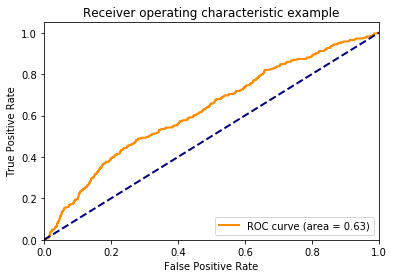

In [112]:
from matplotlib import pyplot as plt

def auc_plot(ytrue, ypredicted):
    fpr, tpr, _ = roc_curve(ytrue, ypredicted, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('ROC: %f' % roc_auc)
    gini_score = 2*roc_auc - 1
    print('Gini: %f' % gini_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
auc_plot(cleanedds['label'], predicted[1])

In [78]:
test_weight = calcWeight(cleanedds['label'])
fpr, tpr, _ = roc_curve(cleanedds['label'], predicted[1], pos_label=1, sample_weight=test_weight)
roc_auc = auc(fpr, tpr)
gini_score = 2*roc_auc - 1
gini_score

0.23336294842620298

In [16]:
rsview = pd.merge(cleanedds['label'], predicted, left_index=True, right_index=True)

In [30]:
rsview

,label,0,1
0,1,0.057027,9.429731e-01
1,0,1.000000,1.939541e-09
2,1,0.015444,9.845562e-01
3,1,0.003002,9.969983e-01
4,0,1.000000,1.399469e-09
...,...,...,...
40071,0,0.998690,1.309607e-03
40072,0,1.000000,6.618199e-41
40073,1,0.026521,9.734795e-01
40074,0,0.005663,9.943373e-01


In [26]:
rsview[rsview.label==0]

,label,0,1
1,0,1.000000,1.939541e-09
4,0,1.000000,1.399469e-09
7,0,1.000000,1.708045e-32
8,0,0.623914,3.760856e-01
9,0,1.000000,2.072553e-07
...,...,...,...
40070,0,1.000000,3.264268e-32
40071,0,0.998690,1.309607e-03
40072,0,1.000000,6.618199e-41
40074,0,0.005663,9.943373e-01


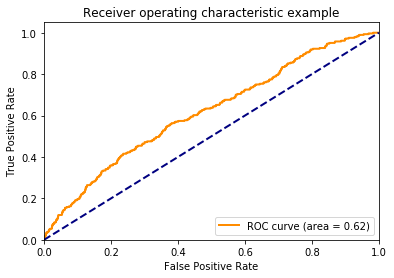

In [81]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

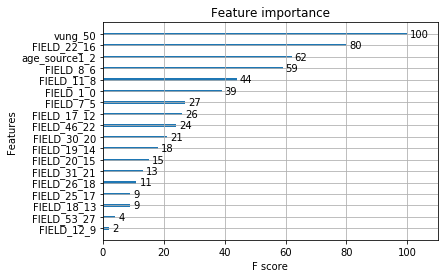

In [236]:
from xgboost import plot_importance
plot_importance(model)

In [ ]:
validate = pd.read_csv('../data/test.csv')
validate